with God's blessing 
and https://www.quantopian.com/posts/the-efficient-frontier-markowitz-portfolio-optimization-in-python

and https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import finance_scripts as fs
from scipy.optimize import minimize
from cvxopt import blas, solvers  
import cvxopt as opt  
import importlib

solvers.options['show_progress'] = False 

In [755]:
# fs.init()
importlib.reload(fs)

<module 'finance_scripts' from '/home/friday/_homescript/finance/lab2/Finance/finance_scripts.py'>

In [4]:
dClosed = pd.read_pickle("close_cleared.pickle") #  цены закрытия
dVolume = pd.read_pickle("volume_cleared.pickle") #  объёмы продаж
print(dClosed.shape[1]) # Число исследуемых компаний

logR = np.log(dClosed / dClosed.shift(1))
e = datetime.strptime('2017-01-02', '%Y-%m-%d')
logR = logR.drop(e)

73


In [5]:
portfolio_num = 10
portfolio_stocks = logR.columns[:portfolio_num]
portfolio_R=logR[portfolio_stocks]

### Article usage begins ...

<br>Функция *random_portfolio()* для генерации случайного портфеля, возвращает среднее значение доходности  и стандартное отклонение доходности $\sigma$ портфеля.

Среднее значение расчитывается как взвешенное средних активов, входящий в портфель: 
$\mu=p^\intercal x$, где 
- $x = (x_1, ..., x_n)$ - вектор весов, полученный с помощью функции rand_weights()
- $p$ - вектор средних доходностей активов в портфеле

Стандартное отклонение расчитывается как $\sigma=\sqrt{x^\intercal Cx}$, где
- $C$ - ковариационная матрица доходностей

In [6]:
mu, sigma = fs.random_portfolio(portfolio_R)
print(f'mu = {mu}, sigma = {sigma}')

mu = 0.0005487217507645033, sigma = 0.0067111515340629885


In [7]:
n_portfolios = 10000
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])

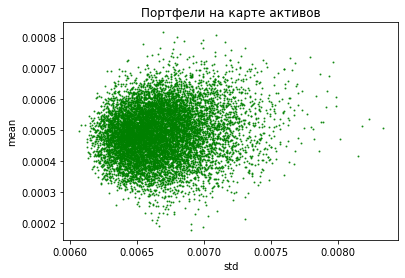

In [8]:
plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g')  
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## Хотим минимизировать риск портфелей

In [16]:
R_mean = np.mean(portfolio_R, axis=0).values 
C = np.cov(portfolio_R.values.T)
target_R = np.arange(-0.0001,0.005,0.0001)
efficient_portfolios_sol = fs.efficient_frontier(R_mean, C, target_R, short_terms=True)

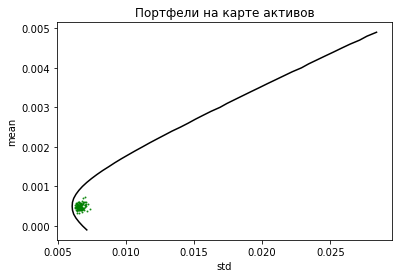

In [10]:
n_portfolios = 100
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])
plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g') 

plt.plot(  efficient_portfolios_sol.T[0], efficient_portfolios_sol.T[1], linestyle='-', color='black', label='efficient frontier')
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## Эффективный портфель

$u(\sigma, E) = E-\gamma\sigma \rightarrow max$ - utility function

Из обоснования мы получили, что решение задачи с соответствующим $\gamma$ будет соответствовать точке на эффективном фронте. При этом меня $-\infty < \gamma < \infty$ мы получим все точки эффетивного фронта

In [14]:
gms = [1,0.5,0.2, 0.18]
opts, xs= fs.optimal_portfolios(R_mean, C, gms,True)

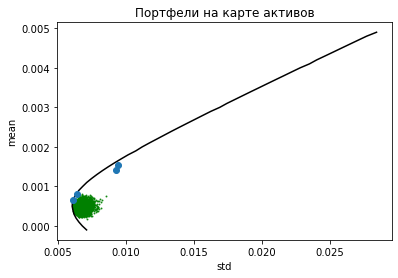

In [17]:
n_portfolios = 10000
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])
plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g') 

plt.plot(  efficient_portfolios_sol.T[0], efficient_portfolios_sol.T[1], linestyle='-', color='black', label='efficient frontier')
plt.plot(  opts.T[0], opts.T[1], 'o', label='optimal portfolio')
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

## VaR

In [25]:
def VaR(E,sigma, u=1.65):
    return -E + u*sigma
    

$Var_\alpha = -E + u_{1-\alpha} \sigma$

для $\alpha = 0.05$: $u_{0.95} = 1.65$

## Задание 3

Рассмотрите набор активов, отобранных в п.2 (10 активов).  Выберете  безрисковый актив (можно виртуальный). Постройте оптимальный (рыночный)  портфель. Сделайте анализ долей активов рыночного портфеля. Оцените VaR доходностей портфеля. Рассмотрите два случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.

В качестве безрискового актива положим виртуальный актив с нулевым отклонением и доходностю $E_f = 0.0001$.

Оптимальный портфель можно посторить максимизируя коэффициент Шарпа:
$$
\frac{E-E_f}{\sigma} \rightarrow max ,
\\
s.t. \sum{x_i}=1, \; x_i>0 \text{ (при запрете коротких продаж)}
$$

Функция *make_opt_portfolio_by_sharpe_ratio()* минимизирует противоположную функцию. Таким образом мы получаем вектор $x=(x_1,...,x_n)$ долей активов, которым задаётся портфель.

#### Короткие продажи запрещены

In [45]:
assets_num = 10 # выбираем 10 активов, которые войдут в портфель
chosen_stocks = logR.columns[:portfolio_num]
assets_R=logR[portfolio_stocks]

In [46]:
R_mean = np.mean(assets_R, axis=0).values 
C = np.cov(assets_R.values.T)

In [47]:
target_R = np.arange(-0.00015,0.0015,0.0001)
efficient_portfolios = fs.efficient_frontier(R_mean, C, target_R, short_terms=False) # строим эффективный фронт портфелей по выбранным активам

In [51]:
Ef = 0.0001
max_sharpe = fs.make_opt_portfolio_by_sharpe_ratio(R_mean, C, Ef, short_terms=False) # вычисляем оптимальный портфель
r_sharp,std_sharp  = fs.portfolio_performance(max_sharpe.x, R_mean, C)

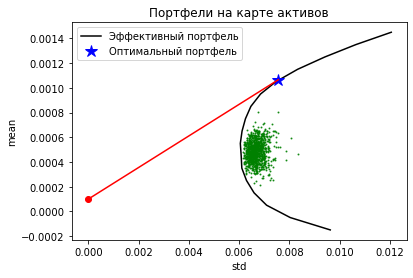

In [52]:
n_portfolios = 1000
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g') 
plt.plot(  efficient_portfolios.T[0], efficient_portfolios.T[1], linestyle='-', color='black', label='Эффективный портфель')
plt.plot(std_sharp, r_sharp, 'b*',markersize=12, label='Оптимальный портфель') 
plt.scatter(0,Ef, c='r')
plt.plot( [0,std_sharp], [Ef, r_sharp],linestyle='-', color='r',)
plt.xlabel('std')  
plt.ylabel('mean')  
plt.legend()
plt.title('Портфели на карте активов')  
plt.show()

In [53]:
print(f'Характиристики оптимального портфеля:\n')
print(f'Доходность: {r_sharp}\nОтклонение: {std_sharp}\nVar: {VaR(r_sharp,std_sharp)}')

Характиристики оптимального портфеля:

Доходность: 0.0010655341256077986
Отклонение: 0.007555254426051833
Var: 0.011400635677377724


In [54]:
print('Доли активов в оптимальном портфеле:')
{stock:x for stock,x in np.column_stack([chosen_stocks, max_sharpe.x])}

Доли активов в оптимальном портфеле:


{'AAD.DE': 1.3056596462394456e-17,
 'ADS.DE': 1.225593859841487e-17,
 'AFX.DE': 0.44785845239738453,
 'ALV.DE': 0.3547245273965024,
 'BAS.DE': 4.769281953237117e-17,
 'BAYN.DE': 2.8557086581684132e-18,
 'BEI.DE': 0.11591741880273072,
 'BMW.DE': 3.34399765862904e-17,
 'BOSS.DE': 0.08149960140338222,
 'BVB.DE': 9.119518837112176e-18}

#### Короткие продажи разрешены

In [55]:
target_R = np.arange(-0.001,0.005,0.0001)
max_sharpe = fs.make_opt_portfolio_by_sharpe_ratio(R_mean, C, Ef, short_terms=True)
r_sharp,std_sharp  = fs.portfolio_performance(max_sharpe.x, R_mean,C)
efficient_portfolios = fs.efficient_frontier(R_mean, C, target_R, short_terms=True)


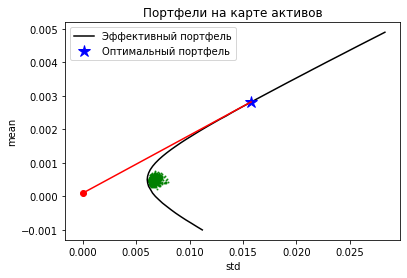

In [56]:
n_portfolios = 1000
means, stds = np.column_stack([  
    fs.random_portfolio(portfolio_R) for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g') 
plt.plot( efficient_portfolios.T[0], efficient_portfolios.T[1], linestyle='-', color='black', label='Эффективный портфель')
plt.plot(std_sharp, r_sharp, 'b*',markersize=12, label='Оптимальный портфель') 
plt.scatter(0,Ef, c='r')
plt.plot( [0,std_sharp], [Ef, r_sharp],linestyle='-', color='r',)
plt.xlabel('std')  
plt.ylabel('mean')  
plt.legend()
plt.title('Портфели на карте активов')  
plt.show()

In [57]:
print(f'Характиристики оптимального портфеля:\n')
print(f'Доходность: {r_sharp}\nОтклонение: {std_sharp}\nVar: {VaR(r_sharp,std_sharp)}')

Характиристики оптимального портфеля:

Доходность: 0.002820088469432153
Отклонение: 0.015759613078267443
Var: 0.023183273109709128


In [58]:
print('Доли активов в оптимальном портфеле:')
{stock:x for stock,x in np.column_stack([chosen_stocks, max_sharpe.x])}

Доли активов в оптимальном портфеле:


{'AAD.DE': -0.2364265635064712,
 'ADS.DE': -0.14434424345136276,
 'AFX.DE': 0.9203434570809378,
 'ALV.DE': 1.5962248769724263,
 'BAS.DE': -0.7903890931230005,
 'BAYN.DE': -0.1804772681005918,
 'BEI.DE': 0.3548805696496505,
 'BMW.DE': -0.6972689618901083,
 'BOSS.DE': 0.19131470699280956,
 'BVB.DE': -0.013857480624289686}

Продаём то, что меньше всего покупали в прошлый раз